In [1]:
import torch
import torch.nn as nn
import torch.cuda
from d2l import torch as d2l
import os

class ChestXRayMapDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data_file):
        self.preprocessed_data = torch.load(preprocessed_data_file)

    def __len__(self):
        return len(self.preprocessed_data)

    def __getitem__(self, index):
        image, label = self.preprocessed_data[index]
        return image, label


# PATH to the pre-processed datasets
train_output_file = "preprocessed_datasets/preprocessed_train_data.pt"
# val_output_file = "preprocessed_datasets/preprocessed_val_data.pt"
test_output_file = "preprocessed_datasets/preprocessed_test_data.pt"


train_map_dataset = ChestXRayMapDataset(train_output_file)
# val_map_dataset = ChestXRayMapDataset(val_output_file)
test_map_dataset = ChestXRayMapDataset(test_output_file)

# Create a data loader
batch_size = 256
train_map_data_loader = torch.utils.data.DataLoader(train_map_dataset, batch_size=batch_size, shuffle=True)
# val_map_data_loader = torch.utils.data.DataLoader(val_map_dataset, batch_size=batch_size, shuffle=True)
test_map_data_loader = torch.utils.data.DataLoader(test_map_dataset, batch_size=batch_size, shuffle=True)


In [2]:
# Implementation of AlexNet
net = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 3))

In [3]:
def try_gpu(index=0):
    """Return GPU(index) if exists, otherwise return cpu()

    Args:
        index (int, optional): index of the GPU you want . Defaults to 0.
    """
    if torch.cuda.device_count() >= (index+1):
        return torch.device(f'cuda:{index}')
    else:
        return torch.device('cpu')

def train_model(net, train_iter, val_iter, num_epochs, lr, device, model_name):
    """Train the AlexNet with a GPU

    Args:
        net (_type_): ALexNet for classifing images
        train_iter (_type_): _description_
        val_iter (_type_): _description_
        num_epochs (_type_): _description_
        lr (_type_): _description_
        device (_type_): _description_
        model_name (_type_): _description_
    """

    #Init the weights with xavier method
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init .xavier_uniform_(m.weight)
    
    net.apply(init_weights)

    #Print the device for training
    net.to(device)
    print('training on:', device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    #d2l package part 0 begin
    def evaluate_accuracy_gpu(net, data_iter, device=None):
        """Compute the accuracy for a model on a dataset using a GPU.

        Defined in :numref:`sec_utils`"""
        if isinstance(net, nn.Module):
            net.eval()  # Set the model to evaluation mode
            if not device:
                device = next(iter(net.parameters())).device
        # No. of correct predictions, no. of predictions
        metric = d2l.Accumulator(2)

        with torch.no_grad():
            for X, y in data_iter:
                if isinstance(X, list):
                    # Required for BERT Fine-tuning (to be covered later)
                    X = [x.to(device) for x in X]
                else:
                    X = X.to(device)
                y = y.to(device)
                metric.add(d2l.accuracy(net(X), y), d2l.size(y))
        return metric[0] / metric[1]
    #d2l package part 0 end

    #d2l package part 1 begin
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    #d2l package part 1 end

    for epoch in range(num_epochs):
        #d2l package part 2 begin
        metric = d2l.Accumulator(3)
        #d2l package part 2 end
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
    #d2l package part 3 begin
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'val acc {val_acc:.3f}')
    #d2l package part 3 end

    #save parameters every 20 epochs
    if (epoch + 1) % 20 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_l
            }
            folder_name = f'model_parameters/{model_name}'
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)
            model_path = f'model_parameters/{model_name}/{model_name}_epoch_{epoch + 1}.pth'
            torch.save(checkpoint, model_path)
            


loss 0.520, train acc 0.772, val acc 0.729


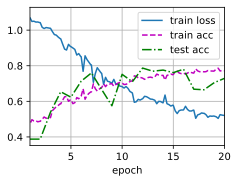

In [4]:
lr, num_epochs = 0.01, 20
train_model(net, train_map_data_loader, test_map_data_loader, num_epochs, lr, try_gpu(), model_name="second_training")